
<div style="text-align: center; line-height: 0; padding-top: 9px;">
  <img src="https://databricks.com/wp-content/uploads/2018/03/db-academy-rgb-1200px.png" alt="Databricks Learning">
</div>



# LAB - Model Development Tracking with *MLflow* 

In this lab, you will learn how to leverage MLflow to track and manage the model development process. First, you will load data from a feature table and create train and test splits. Then, you train a classification model and track the training process with MLflow. While MLflow automatically logs all metadata and artifacts with autologging, you will do it manually to learn how to use logging API.

**Lab Outline:**

* **Task 1.** Load dataset from feature store table
* **Task 2.** Define model hyperparameters
* **Task 3.** Track the model with MLflow 
* **Task 4.** Log custom figure
* **Task 5.** Review the model details via the UI in the Experiment runs.



## Requirements

Please review the following requirements before starting the lesson:

* To run this notebook, you need to use one of the following Databricks runtime(s): **13.3.x-cpu-ml-scala2.12 13.3.x-scala2.12**


## Classroom Setup

Before starting the demo, run the provided classroom setup scripts. 

**📌 Note:** In this lab you will register MLflow models with Unity Catalog. Therefore, you will need to run the next code block to **set model registery URI to UC**. 


In [0]:
%pip install --upgrade 'mlflow-skinny[databricks]'
dbutils.library.restartPython()

Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
  Using cached mlflow_skinny-2.19.0-py3-none-any.whl (5.9 MB)
  Using cached databricks_sdk-0.40.0-py3-none-any.whl (629 kB)
  Using cached opentelemetry_api-1.29.0-py3-none-any.whl (64 kB)
  Using cached opentelemetry_sdk-1.29.0-py3-none-any.whl (118 kB)
  Using cached cachetools-5.5.0-py3-none-any.whl (9.5 kB)
  Using cached google_auth-2.37.0-py2.py3-none-any.whl (209 kB)
  Using cached Deprecated-1.2.15-py2.py3-none-any.whl (9.9 kB)
  Using cached importlib_metadata-8.5.0-py3-none-any.whl (26 kB)
  Using cached zipp-3.21.0-py3-none-any.whl (9.6 kB)
  Using cached opentelemetry_semantic_conventions-0.50b0-py3-none-any.whl (166 kB)
  Attempting uninstall: zipp
    Found existing installation: zipp 3.8.0
    Not uninstalling zipp at /databricks/python3/lib/python3.10/site-packages, outside environment /local_disk0/.ephemeral_nfs/envs/pythonEnv-aaf15a77-4c4e-41d1-9c6f-4a689e57def3
  

Next, this script will define configuration variables necessary for the demo. Execute the following cell:

In [0]:
%run ../Includes/Classroom-Setup-1.LAB

Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.


Resetting the learning environment:
| dropping the catalog "labuser8100238_1734654409_km6w_da"...(0 seconds)

Skipping install of existing datasets to "dbfs:/mnt/dbacademy-datasets/machine-learning-model-development/v01"

Validating the locally installed datasets:
| listing local files...(0 seconds)
| validation completed...(0 seconds total)
Creating & using the catalog "labuser8100238_1734654409_km6w_da"...(1 seconds)


2024/12/20 02:19:41 INFO databricks.feature_store._compute_client._compute_client: Setting columns ['customerID'] of table 'labuser8100238_1734654409_km6w_da.default.telco' to NOT NULL.
2024/12/20 02:19:44 INFO databricks.feature_store._compute_client._compute_client: Setting Primary Keys constraint ['customerID'] on table 'labuser8100238_1734654409_km6w_da.default.telco'.
2024/12/20 02:19:53 INFO databricks.feature_store._compute_client._compute_client: Created feature table 'labuser8100238_1734654409_km6w_da.default.telco'.



Predefined tables in "labuser8100238_1734654409_km6w_da.default":
| telco

Predefined paths variables:
| DA.paths.working_dir: dbfs:/mnt/dbacademy-users/labuser8100238_1734654409@vocareum.com/machine-learning-model-development
| DA.paths.datasets:    dbfs:/mnt/dbacademy-datasets/machine-learning-model-development/v01

Setup completed (34 seconds)


**Other Conventions:**

Throughout this demo, we'll refer to the object `DA`. This object, provided by Databricks Academy, contains variables such as your username, catalog name, schema name, working directory, and dataset locations. Run the code block below to view these details:

In [0]:
print(f"Username:          {DA.username}")
print(f"Catalog Name:      {DA.catalog_name}")
print(f"Schema Name:       {DA.schema_name}")
print(f"Working Directory: {DA.paths.working_dir}")
print(f"User DB Location:  {DA.paths.datasets}")

Username:          labuser8100238_1734654409@vocareum.com
Catalog Name:      labuser8100238_1734654409_km6w_da
Schema Name:       default
Working Directory: dbfs:/mnt/dbacademy-users/labuser8100238_1734654409@vocareum.com/machine-learning-model-development
User DB Location:  dbfs:/mnt/dbacademy-datasets/machine-learning-model-development/v01


## Tasks 1 - Load Dataset from Feature Store Table

Use the feature store to load a dataset from a specific table.
   - **Load Dataset:** Utilize MLflow's `load_delta` function to seamlessly retrieve and load the dataset from the Feature Store table named **`"telco"`** in the specified catalog and schema `("DA.catalog_name" and "DA.schema_name")`. 
   - Convert dataset to `pandas` dataframe and explore the loaded dataset.

### Load Data

In [0]:
# Import the necessary library for MLflow
import mlflow

# Load the feature dataset using mlflow.data
feature_dataset = mlflow.data.load_delta(
    table_name=f"{DA.catalog_name}.{DA.schema_name}.telco",
    name="telco"
)

# convert the dataset to pandas df and drop the customerID column
feature_data_pd = feature_dataset.df.drop("customerID").toPandas()

# Convert all feature_data_pd columns to float
feature_data_pd = feature_data_pd.astype(float)

# inspect final dataset
display(feature_data_pd)

SeniorCitizen,tenure,MonthlyCharges,gender,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,TotalCharges,Churn
0.0,1.0,29.85,1.0,1.0,0.0,1.0,2.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2716.0,0.0
0.0,34.0,56.95,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,2.0,1.0,1.0,1760.0,0.0
0.0,2.0,53.85,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,508.0,1.0
0.0,45.0,42.3,0.0,0.0,0.0,1.0,2.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,2.0,1.0,2.0,1696.0,0.0
0.0,2.0,70.7,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1242.0,1.0
0.0,8.0,99.65,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,6139.0,1.0
0.0,22.0,89.1,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,3.0,1826.0,0.0
0.0,10.0,29.75,1.0,0.0,0.0,1.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2818.0,0.0
0.0,28.0,104.8,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,2855.0,1.0
0.0,62.0,56.15,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,2.0,1.0,2.0,3215.0,0.0


### Train / Test Split

Split the dataset into training and testing sets.

In [0]:
# Import necessary libraries
import mlflow.sklearn  # For MLflow integration
from sklearn.model_selection import train_test_split  # For splitting the dataset into training and testing sets

# Split the dataset into training and testing sets
target_col = "Churn"
X_all = feature_data_pd.drop(labels=target_col, axis=1)
y_all = feature_data_pd[target_col]
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, train_size=0.8, random_state=42)

## Task 2 - Define Model Hyperparameters

In this lab, you will train a classification model. In this task define parameters for a Decision Tree Model.

In [0]:
# Define Decision Tree Classifier parameters
dtc_params = {
    'criterion': 'gini',
    'max_depth': 50,
    'min_samples_split': 20,
    'min_samples_leaf': 5
}

##Task 3 - Track the Model Development  with MLflow

Initialize an MLflow run.
   - **Initialize MLflow Run:** Start an MLflow run to track the model development process. This allows for systematic recording of parameters, metrics, and artifacts associated with the model.

   - **Logging Model Details:** Utilize MLflow tracking to log essential information about the model, including parameters, metrics, and other relevant artifacts.

In [0]:
import mlflow
mlflow.set_registry_uri("databricks-uc")

In [0]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score
from sklearn.tree import DecisionTreeClassifier

from mlflow.models.signature import infer_signature

# set the path for mlflow experiment
mlflow.set_experiment(f"/Users/{DA.username}/LAB-1-Model-Development-Tracking-with-MLflow")

# Turn off autologging as we want to log the model manually
mlflow.autolog(disable=True)

# Start an MLFlow run
with mlflow.start_run(run_name="Model Developing Tracking with MLflow Lab") as run:
    # Log the dataset
    mlflow.log_input(feature_dataset, context="source")
    mlflow.log_input(mlflow.data.from_pandas(X_train, source=feature_dataset.source), context="training")
    mlflow.log_input(mlflow.data.from_pandas(X_test, source=feature_dataset.source), context="test")

    # Log parameters
    mlflow.log_params(dtc_params)

    # Fit the model
    dtc = DecisionTreeClassifier(**dtc_params)
    dtc_mdl = dtc.fit(X_train, y_train)

    # Define model signature
    signature = infer_signature(X_all, y_all)
   
    # Log the model
    # Define the model name based on the feature store catalog and schema
    model_name = f"{DA.catalog_name}.{DA.schema_name}.churnmodel"
    mlflow.sklearn.log_model(
        sk_model=dtc_mdl,
        artifact_path="model-artifacts",
        signature=signature,
        registered_model_name=model_name
    )

    # Evaluate on the training set
    y_pred_train = dtc_mdl.predict(X_train)
    mlflow.log_metric("train_accuracy", accuracy_score(y_train, y_pred_train))
    mlflow.log_metric("train_precision", precision_score(y_train, y_pred_train))
    mlflow.log_metric("train_recall", recall_score(y_train, y_pred_train))
    mlflow.log_metric("train_f1", f1_score(y_train, y_pred_train))

    # Evaluate on the test set
    y_pred_test = dtc_mdl.predict(X_test)
    mlflow.log_metric("test_accuracy", accuracy_score(y_test, y_pred_test))
    mlflow.log_metric("test_precision", precision_score(y_test, y_pred_test))
    mlflow.log_metric("test_recall", recall_score(y_test, y_pred_test))
    mlflow.log_metric("test_f1", f1_score(y_test, y_pred_test))

2024/12/20 02:23:26 INFO mlflow.tracking.fluent: Experiment with name '/Users/labuser8100238_1734654409@vocareum.com/LAB-1-Model-Development-Tracking-with-MLflow' does not exist. Creating a new experiment.
/local_disk0/.ephemeral_nfs/envs/pythonEnv-aaf15a77-4c4e-41d1-9c6f-4a689e57def3/lib/python3.10/site-packages/mlflow/types/utils.py:435: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Successfully registered model 'labuser8100238_1734654409_km6w_da.default.churnmodel'.


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Created version '1' of model 'labuser8100238_1734654409_km6w_da.default.churnmodel'.


🏃 View run Model Developing Tracking with MLflow Lab at: https://dbc-d9456cf0-b376.cloud.databricks.com/ml/experiments/512858688199601/runs/801124b1150b438d8a85c16edf0c4917
🧪 View experiment at: https://dbc-d9456cf0-b376.cloud.databricks.com/ml/experiments/512858688199601


## Task 4 - Log Custom Figure

**Log Custom Figure/Visualization:** Include the logging of a custom figure, such as a confusion matrix or any relevant visualization, to further illustrate the model's behavior. This visual representation can be valuable for model evaluation and interpretation.

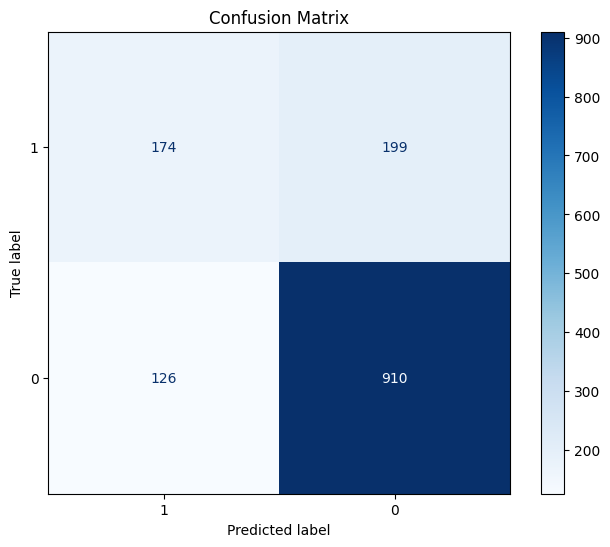

In [0]:
# ANSWER    
# Import necessary libraries for creating and displaying a confusion matrix
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from mlflow.client import MlflowClient
client = MlflowClient()

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred_test, labels=[1, 0])

# Create a figure object and axes for the confusion matrix plot
fig, ax = plt.subplots(figsize=(8, 6))

# Create a ConfusionMatrixDisplay object with the computed confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[1, 0])

# Plot the confusion matrix using the created axes and specified color map
disp.plot(cmap=plt.cm.Blues, ax=ax)

# Set the title of the plot
ax.set_title('Confusion Matrix')

# Log the confusion matrix figure to MLflow
client.log_figure(run.info.run_id, figure=fig, artifact_file="confusion_matrix.png")

## Task 5 - Review model details via the UI
To review the model details via the MLflow UI in the Experiment runs, follow these steps:

+ Step 1: Go to the "Experiments" Section

+ Step 2: Locate Your Experiment

+ Step 3: Review Run Details

+ Step 4: Reviewing Artifacts and Metrics

+ Step 5: Viewing Confusion Matrix Image

+ Step 6: Retrieve Model Details


## Clean up Classroom

Run the following cell to remove lessons-specific assets created during this lesson.

In [0]:
DA.cleanup()


## Conclusion


In conclusion, this lab showcased the effectiveness of MLflow in seamlessly managing the model development process. Leveraging MLflow's features, such as experiment tracking, custom metric logging, and artifact storage, enhances collaboration and ensures reproducibility. The ability to review model details through the MLflow UI provides valuable insights into model performance and aids in making informed decisions.


&copy; 2024 Databricks, Inc. All rights reserved.<br/>
Apache, Apache Spark, Spark and the Spark logo are trademarks of the 
<a href="https://www.apache.org/">Apache Software Foundation</a>.<br/>
<br/><a href="https://databricks.com/privacy-policy">Privacy Policy</a> | 
<a href="https://databricks.com/terms-of-use">Terms of Use</a> | 
<a href="https://help.databricks.com/">Support</a>